In [5]:
# Import libraries

import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt


In [6]:
# Device selection
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

kwargs = {'num_workers': 1}
if torch.cuda.is_available():
    kwargs['pin_memory'] = True


Using MPS


In [7]:
# Hyperparameters

batch_size = 64
latent_size = 32
init_channels = 8
class_size = 10  # Number of classes in MNIST (0-9)
epochs = 10


In [8]:
# Data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False, **kwargs)


In [ ]:
# Helper function for one-hot encoding
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)


In [ ]:
class CVAE(nn.Module):
    def __init__(self, image_channels, init_channels, latent_size, class_size):
        super(CVAE, self).__init__()
        self.image_channels = image_channels
        self.latent_size = latent_size
        self.class_size = class_size
        self.init_channels = init_channels
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, init_channels, kernel_size=3, stride=2, padding=1),     # (1, 28, 28) -> (8, 14, 14)
            nn.ReLU(),
            nn.Conv2d(init_channels, init_channels*2, kernel_size=3, stride=2, padding=1),    # (8, 14, 14) -> (16, 7, 7)
            nn.ReLU(),
            nn.Conv2d(init_channels*2, init_channels*4, kernel_size=3, stride=2, padding=1),  # (16, 7, 7) -> (32, 4, 4)
            nn.ReLU(),
            nn.Conv2d(init_channels*4, 64, kernel_size=3, stride=1, padding=0),               # (32, 4, 4) -> (64, 2, 2)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=0),                          # (64, 2, 2) -> (64, 1, 1)
            nn.ReLU()
        )
        
        # FC layers to get mu and logvar
        self.fc1 = nn.Linear(64 + self.class_size, 128)
        self.fc_mu = nn.Linear(128, latent_size)
        self.fc_logvar = nn.Linear(128, latent_size)
        self.fc2 = nn.Linear(latent_size + self.class_size, 64)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=1, padding=0),  # (64, 1, 1) -> (64, 2, 2)
            nn.ReLU(),
            nn.ConvTranspose2d(64, init_channels*4, kernel_size=3, stride=1, padding=0),  # (64, 2, 2) -> (32, 4, 4)
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels*4, init_channels*2, kernel_size=3, stride=2, padding=1),  # (32, 4, 4) -> (16, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels*2, init_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16, 7, 7) -> (8, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels, image_channels, kernel_size=4, stride=2, padding=1)  # (8, 14, 14) -> (1, 28, 28)
        )
    
    def encode(self, x, c):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        inputs = torch.cat([h, c], 1)
        h_fc = F.relu(self.fc1(inputs))
        mu = self.fc_mu(h_fc)
        logvar = self.fc_logvar(h_fc)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sample = mu + eps * std
        return sample
    
    def decode(self, z, c):
        inputs = torch.cat([z, c], 1)
        h = F.relu(self.fc2(inputs))
        h = h.view(-1, 64, 1, 1)
        return torch.sigmoid(self.decoder(h))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar


In [ ]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction + KL divergence losses summed over all elements and batch
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # -0.5 * torch.sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [ ]:
# Train and Test functions
def train(model, optimizer, epoch, losses):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        
        labels_onehot = one_hot(labels, class_size)
        recon_batch, mu, logvar = model(data, labels_onehot)
        
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    
    losses.append(train_loss / len(train_loader.dataset))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(model, epoch, losses):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), labels.to(device)
            
            labels_onehot = one_hot(labels, class_size)
            recon_batch, mu, logvar = model(data, labels_onehot)
            test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().numpy()
            
            if i == 0:
                n = min(data.size(0), 5)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(-1, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'cvae_reconstruction_' + str(f"{epoch:02}") + '.png', nrow=n)

    losses.append(test_loss / len(test_loader.dataset))
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [13]:
# Initialize and train the CVAE model
model = CVAE(image_channels=1, init_channels=init_channels, latent_size=latent_size, class_size=class_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
test_losses = []

print("Starting CVAE training...")
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_losses)
    test(model, epoch, test_losses)
    
    # Generate samples for each class
    with torch.no_grad():
        # Create one-hot encoding for all 10 classes
        c = torch.eye(10, 10).to(device)  # Identity matrix for one-hot encoding
        sample = torch.randn(10, latent_size).to(device)
        sample = model.decode(sample, c).cpu()
        save_image(sample.view(10, 1, 28, 28), 
                  str(f"cvae_sample_{epoch:02}.png"))

print("Training completed!")


Starting CVAE training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 614.868591
Train Epoch: 1 [1280/60000 (2%)]	Loss: 584.211975
Train Epoch: 1 [2560/60000 (4%)]	Loss: 398.126648
Train Epoch: 1 [3840/60000 (6%)]	Loss: 285.060455
Train Epoch: 1 [5120/60000 (9%)]	Loss: 240.374435
Train Epoch: 1 [6400/60000 (11%)]	Loss: 225.165527
Train Epoch: 1 [7680/60000 (13%)]	Loss: 214.577240
Train Epoch: 1 [8960/60000 (15%)]	Loss: 210.577774
Train Epoch: 1 [10240/60000 (17%)]	Loss: 198.468994
Train Epoch: 1 [11520/60000 (19%)]	Loss: 198.501511
Train Epoch: 1 [12800/60000 (21%)]	Loss: 194.581650
Train Epoch: 1 [14080/60000 (23%)]	Loss: 196.298767
Train Epoch: 1 [15360/60000 (26%)]	Loss: 205.743881
Train Epoch: 1 [16640/60000 (28%)]	Loss: 196.539368
Train Epoch: 1 [17920/60000 (30%)]	Loss: 193.056625
Train Epoch: 1 [19200/60000 (32%)]	Loss: 202.289093
Train Epoch: 1 [20480/60000 (34%)]	Loss: 191.911880
Train Epoch: 1 [21760/60000 (36%)]	Loss: 185.104080
Train Epoch: 1 [23040/60000 (38%)]	Loss: 188.797684
Tr

Train losses: [np.float32(205.19226), np.float32(144.21182), np.float32(133.10277), np.float32(127.96524), np.float32(125.27095), np.float32(123.45314), np.float32(122.03868), np.float32(120.79906), np.float32(118.95054), np.float32(117.27289)]
Test losses: [np.float32(156.96455), np.float32(136.67743), np.float32(130.18228), np.float32(126.020424), np.float32(123.831825), np.float32(121.881836), np.float32(120.9647), np.float32(119.274284), np.float32(117.306175), np.float32(115.7241)]


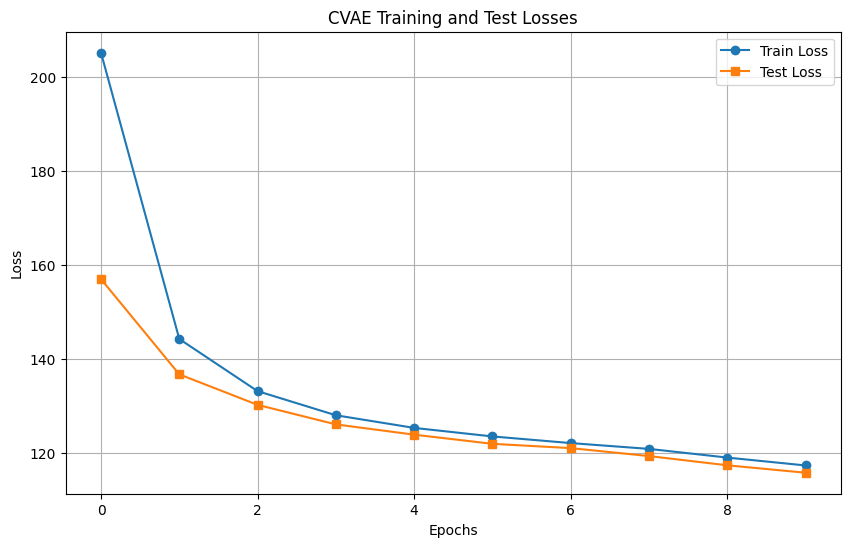

In [14]:
# Visualize the training and test losses
print("Train losses:", train_losses)
print("Test losses:", test_losses)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CVAE Training and Test Losses')
plt.grid(True)
plt.legend()
plt.show()


In [15]:
# Save the trained model
torch.save(model.state_dict(), 'cvae_model_mnist.pth')
print("Model saved as 'cvae_model_mnist.pth'")


Model saved as 'cvae_model_mnist.pth'


In [ ]:
# Load the model (skip training for future use)
# model = CVAE(image_channels=1, init_channels=init_channels, latent_size=latent_size, class_size=class_size).to(device)
# model.load_state_dict(torch.load('cvae_model_mnist.pth'))
# print("Model loaded successfully!")


In [ ]:
# Conditional generation functions

def generate_digit(model, digit, num_samples=10):
    model.eval()
    with torch.no_grad():
        c = torch.zeros(num_samples, class_size).to(device)
        c[:, digit] = 1 
        z = torch.randn(num_samples, latent_size).to(device)
        
        sample = model.decode(z, c).cpu())
        save_image(sample.view(num_samples, 1, 28, 28), 
                  f"cvae_generated_digit_{digit}.png", nrow=5)
        print(f"Generated {num_samples} samples of digit {digit}")

def generate_all_digits(model, num_samples_per_digit=8):

    model.eval()
    with torch.no_grad():
        all_samples = []
        
        for digit in range(10):
            c = torch.zeros(num_samples_per_digit, class_size).to(device)
            c[:, digit] = 1
            z = torch.randn(num_samples_per_digit, latent_size).to(device)
            
            sample = model.decode(z, c).cpu()
            all_samples.append(sample)
        
        all_samples = torch.cat(all_samples, dim=0)
        save_image(all_samples.view(-1, 1, 28, 28), 
                  "cvae_all_digits_generated.png", nrow=num_samples_per_digit)
        print(f"Generated {num_samples_per_digit} samples for each digit (0-9)")

# Generate samples for specific digits
print("Generating conditional samples...")
generate_digit(model, 3, num_samples=10)  # Generate digit 3
generate_digit(model, 7, num_samples=10)  # Generate digit 7
generate_all_digits(model, num_samples_per_digit=8)  # Generate all digits


Generating conditional samples...
Generated 10 samples of digit 3
Generated 10 samples of digit 7
Generated 8 samples for each digit (0-9)


In [ ]:
# Latent space interpolation between different classes

def interpolate_between_classes(model, class1, class2, num_steps=10):
    model.eval()
    with torch.no_grad():
        c1 = torch.zeros(1, class_size).to(device)
        c1[0, class1] = 1
        
        c2 = torch.zeros(1, class_size).to(device)
        c2[0, class2] = 1
        
        z1 = torch.randn(1, latent_size).to(device)
        z2 = torch.randn(1, latent_size).to(device)
        
        interpolated_samples = []
        
        for i in range(num_steps):
            alpha = i / (num_steps - 1)
            z_interp = (1 - alpha) * z1 + alpha * z2
            c_interp = (1 - alpha) * c1 + alpha * c2
            sample = model.decode(z_interp, c_interp).cpu()
            interpolated_samples.append(sample)
        
        interpolated_samples = torch.cat(interpolated_samples, dim=0)
        save_image(interpolated_samples.view(-1, 1, 28, 28), 
                  f"cvae_interpolation_{class1}_to_{class2}.png", nrow=num_steps)
        print(f"Generated interpolation from class {class1} to class {class2}")

print("Generating class interpolations...")
interpolate_between_classes(model, 0, 1, num_steps=10)  # 0 to 1
interpolate_between_classes(model, 3, 8, num_steps=10)  # 3 to 8
interpolate_between_classes(model, 6, 9, num_steps=10)  # 6 to 9


Generating class interpolations...
Generated interpolation from class 0 to class 1
Generated interpolation from class 3 to class 8
Generated interpolation from class 6 to class 9
